# Unsupervised Planogram Compliance

http://openaccess.thecvf.com/content_ECCV_2018/html/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.html
http://openaccess.thecvf.com/content_ECCV_2018/papers/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.pdf

In [1]:
# IMPORTING LIBRARIES

import os
import io
import sys
import numpy as np
from sklearn.cluster import KMeans
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Hyperparameters 

In [2]:
# KERNEL SIZE
k = 20
k_des = 100

# STRIDE
s = 20
s_des = 100

# NUMBER OF CLUSTERS 
n_clusters = 3
n_clusters_des = 6

### 2. Input Rack Image

Shape of rack image: (1350, 4114, 3)


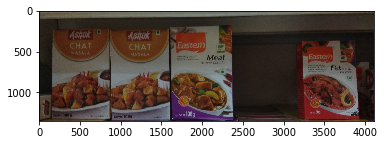

In [3]:
def read_rackImage(image_name):

    img=cv2.imread(image_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    X=np.array(img)
    print('Shape of rack image: ' + str(X.shape))
    
    return X, img
    
X, img = read_rackImage('set1_rack.jpeg')

### 3. Crop Rack Image

Shape of cropped rack image 1: (1215, 4114, 3)
Shape of cropped rack image 2: (1200, 4100, 3)


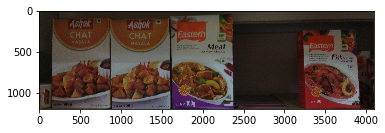

In [4]:
def crop_rackImage(X, img, k):

    h = np.shape(X)[0]
    
    # Step 1
    X = X[int(0.1*h):, :]
    print('Shape of cropped rack image 1: ' + str(np.shape(X)))
    
    h, w = np.shape(X[:,:,-1])
    
    # Step 2
    X = X[:h - h%k, :w - w%k]
    print('Shape of cropped rack image 2: ' + str(np.shape(X)))
    
    plt.imshow(X)
    
    return X, img

X, img = crop_rackImage(X, img, k)

### 4. Retrive Cropped Rack Image Details

In [5]:
def info_rackImage(X, img):
    
    h, w, channels = np.shape(X)
    info = (X, img, h, w, channels)
    
    return info

info = info_rackImage(X, img)

### 5. Sliding Window

In [6]:
def sliding_window(info, k, s):

    X, h, w = info[0], info[2], info[3]
    X1np=[]
    
    for i in range(h//k):
        for j in range(w//k):
            
            window = X[i*k:i*k + k, j*k:j*k + k, :]
            X1np.append(np.asarray(window))
    
    X1np = np.asarray(X1np)
    
    # Flatten List of Sliding Windows
    X2np = X1np.reshape(X1np.shape[0], X1np.shape[1]*X1np.shape[2]*X1np.shape[3])
            
    return X1np, X2np

X1np ,X2np = sliding_window(info, k, s)
X1np_des, X2np_des = sliding_window(info, k_des, s_des)
print('Shape of list of sliding window instances (without feature descriptors): ' + str(X1np.shape) + ' '+str(X2np.shape))
print('Shape of list of sliding window instances (with feature descriptors): ' + str(X1np_des.shape) + ' '+str(X2np_des.shape))

Shape of list of sliding window instances (without feature descriptors): (12300, 20, 20, 3) (12300, 1200)
Shape of list of sliding window instances (with feature descriptors): (492, 100, 100, 3) (492, 30000)


## 6. SURF Feature Descriptors

In [7]:
X_des=[]

#Hyperparameter
n_features = 5

def surf_rackImage(X1np_des, n_features):
    
    for i in range(X1np_des.shape[0]):
        
        arr = np.zeros((n_features*32))
        surf = cv2.xfeatures2d.SURF_create()
        orb = cv2.ORB_create(nfeatures = n_features)
        keypoints, descriptors= orb.detectAndCompute(X1np_des[i], None)
        
        des = np.asarray(descriptors)
        des = des.flatten()

        for j in range(des.shape[0]):
            if des.shape[0] != 1:
                arr[j] = arr[j] + des[j]
        
        X_des.append(arr)
    
    return X_des

X_des=surf_rackImage(X1np_des,n_features)

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


## 6. Implement Kmeans_Cluster

In [31]:
def Kmeans_Cluster(X2np, n_clusters):

    kmeans = KMeans(n_clusters = n_clusters, random_state = 0,verbose = 0).fit_predict(X2np)
    print('Shape of Kmeans output: '+ str(kmeans.shape))
    
    return kmeans

kmeans = Kmeans_Cluster(X2np, n_clusters)
kmeans_des = Kmeans_Cluster(X2np_des, n_clusters_des)

Shape of Kmeans output: (12300,)
Shape of Kmeans output: (492,)


## 7. Image after Cluster Division

Shape of clustered rack image: (1200, 4100)


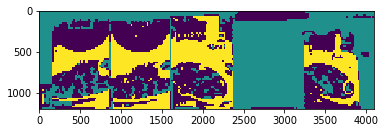

In [32]:
def cluster_rackImage(kmeans, info, n_clusters):

    (_, _, h, w, _) = info
    kmeans1 = kmeans.reshape(h//k, w//k)
    color_map = np.zeros((h, w))

    for i in range(kmeans1.shape[0]):
        for j in range(kmeans1.shape[1]):
            
            col=255/(n_clusters - 1)
            temp = col*kmeans1[i][j] 
            
            color_map[i*k : i*k + k, j*k : j*k + k] = np.full((k,k),temp)
    
    print('Shape of clustered rack image: ' + str(np.shape(color_map)))
        
    return color_map
    
color_map = cluster_rackImage(kmeans, info, n_clusters)
plt.imshow(color_map)

## 7.1 Image after Cluster Division (Properly Processed)

[4389 5093 2818] {0: 4389, 1: 5093, 2: 2818}
Shape of clustered rack image: (1200, 4100)


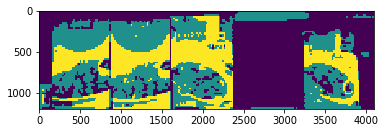

In [33]:
def processCluster_rackImage(kmeans, n_clusters):
    
    kmeans1 = kmeans
    
    unique, counts = np.unique(kmeans, return_counts=True)
    pixel_count = dict(zip(unique, counts))
         
    print(counts, pixel_count)
    
    max_pixel = np.argmax(counts)
    min_pixel = np.argmin(counts)
    
    for i in range(kmeans.shape[0]):
        if kmeans[i] == max_pixel:
            kmeans1[i] = n_clusters + 0
        elif kmeans1[i] == min_pixel:
            kmeans1[i] = n_clusters + 2
        else:
            kmeans1[i] = n_clusters + 1
            
    kmeans1 = kmeans1 - n_clusters
    
    color_map = cluster_rackImage(kmeans1, info, n_clusters)
    
    return color_map
    
color_map2 = processCluster_rackImage(kmeans, n_clusters)
plt.imshow(color_map2)

color_map = color_map2

In [ ]:
def sliding_window(info, k, s):

    X, h, w = info[0], info[2], info[3]
    X1np=[]
    
    for i in range(h//k):
        for j in range(w//k):
            
            window = X[i*k:i*k + k, j*k:j*k + k, :]
            X1np.append(np.asarray(window))
    
    X1np = np.asarray(X1np)
    
    # Flatten List of Sliding Windows
    X2np = X1np.reshape(X1np.shape[0], X1np.shape[1]*X1np.shape[2]*X1np.shape[3])
            
    return X1np, X2np

X1np, X2np = sliding_window(info, k, s)
print('Shape of list of sliding window instances: ' + str(X1np.shape) + ' ' + str(X2np.shape))


img=cv2.drawKeypoints(gray,kp)

### 8. Object Graphs

In [291]:
def momentum(y):
    
    #Hyperparameter
    beta = 0.99
    
    weighted_y = [y[0], ]
    for i in range(1, np.array(y).shape[0]):
        temp_y = beta*weighted_y[i-1] + (1 - beta)*y[i]
        weighted_y.append(temp_y)
        
    weighted_y = np.asarray(weighted_y)    
    
    return weighted_y

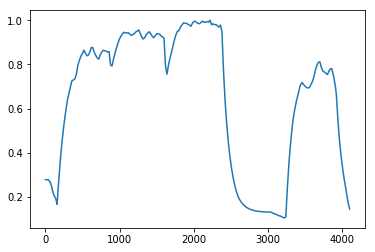

In [292]:
def objectExpectancy_rackImage_1(color_map, info):
        
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            if color_map[j, i] != 0: 
                sum += 1
        
        y_cluster.append(sum)

    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)
    
    return y_cluster

plt.plot(objectExpectancy_rackImage_1(color_map, info))
plt.show()

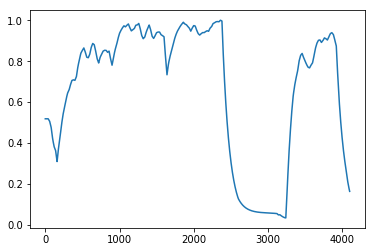

In [293]:
def weightedObjectExpectancy_rackImage_1(color_map, info):
    
    h = info[2]
    
    # Hyperparameter
    regions = 3
    
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            
            if color_map[j, i] != 0: 
                if j < 1*h/3:
                    sum += 1
                elif j < 2*h/3:
                    sum += 4
                else: 
                    sum += 9
                    
        y_cluster.append(sum)
    
    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)

    return y_cluster

plt.plot(weightedObjectExpectancy_rackImage_1(color_map, info))
plt.show()

#### Notes
1) Changing the following things give different results:
<br/>a) col
<br/>b) n_clusters
<br/>c) kernel_size(k=20 is best till now)

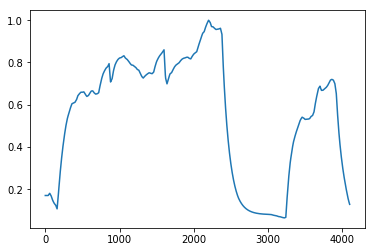

In [294]:
def objectExpectancy_rackImage_2(color_map, info):
        
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            if color_map[j, i] != 0: 
                sum += color_map[j, i]
        
        y_cluster.append(sum)

    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)
    
    return y_cluster

plt.plot(objectExpectancy_rackImage_2(color_map, info))
plt.show()

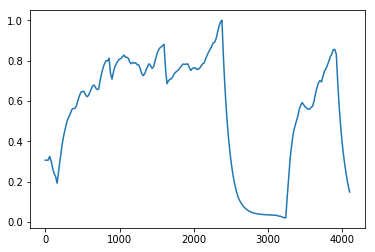

In [295]:
def weightedObjectExpectancy_rackImage_2(color_map, info):
    
    h = info[2]
    
    # Hyperparameter
    regions = 3
    
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            
            if color_map[j, i] != 0: 
                if j < 1*h/3:
                    sum += 1*color_map[j, i]
                elif j < 2*h/3:
                    sum += 4*color_map[j, i]
                else: 
                    sum += 9*color_map[j, i]
                    
        y_cluster.append(sum)
    
    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)

    return y_cluster

plt.plot(weightedObjectExpectancy_rackImage_2(color_map, info))
plt.show()